In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus= tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)   # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V2 import *
import aux_func_numpy as debug

float_pres = 'float64' # Definindo a precisão padrão para as análises

In [2]:
# Função que define a taxa de aprendizagem para diferentes
# iterações de treino, a ideia é começar com uma taxa grande e 
# diminuir ao longo do treino para "refinar" a aprendizagem da rede

def scheduler(epoch, lr):
    if epoch < 1:
        return 10**-2
    elif epoch < 2:
        return 10**-3
    else:
        return 10**-4
    
# Passando para o keras a função scheduler
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [8]:
# Definindo a função de ativação utilizada na arquitetura da rede
ativ_func=lambda x: tf.nn.elu(x)+1

# Definindo a função de regularização das ativações
regul_func=lambda x: 0.4019*tf.math.reduce_sum((x-1)**2)

def Inf_Norm(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_max(tf.math.abs(y_pred - y_true), axis=-1)

class Burguers_layer(keras.layers.Layer):
    """Criando uma camada de rede neural cuja superclasse é a camada
    do keras para integrar o algoritmo do WENO com a rede neural"""
    
    def __init__(self, t_final, Δx, CFL, fronteira):
        """
        Construtor da classe
        --------------------------------------------------------------------------------------
        t_final      (float): tamanho máximo da variação temporal
        Δx           (float): distância espacial dos pontos na malha utilizada
        CFL          (float): constante utilizada para determinar o tamanho da malha temporal
        fronteira (function): função que determina o comportamento do algoritmo na fronteira
        --------------------------------------------------------------------------------------
        """
        super(Burguers_layer, self).__init__(dtype=float_pres)                 # Chamando o inicializador da superclasse
        self.t_final = tf.Variable(t_final, dtype=float_pres, trainable=False) # Definindo t_final como variável do tensorflow
        
        # Salvando os valores dos parâmetros do construtor no objeto
        self.Δx        = Δx
        self.CFL       = CFL
        self.fronteira = fronteira
        
    def build(self, input_shape):
        """
        Função para compor as camadas que constituem essa camada da rede neural
        ------------------------------------------------------------------------
        input_shape (?): não é utilizado por essa função
        ------------------------------------------------------------------------
        """
        self.layers=[]
        wei_reg = tf.keras.regularizers.L2(0*10**-3)                                                                        # Regularização dos pesos da rede 
        self.layers.append(tf.keras.layers.ZeroPadding1D(padding=2))                                                        # Camada de padding de zeros em 1 dimensão
        self.layers.append(keras.layers.Conv1D(5, 5, activation='elu',     dtype=float_pres, kernel_regularizer=wei_reg)) # Camada de convolução em 1 dimensão
        self.layers.append(tf.keras.layers.ZeroPadding1D(padding=2))                                                        # Camada de padding de zeros em 1 dimensão
        self.layers.append(keras.layers.Conv1D(3, 5, activation='elu',     dtype=float_pres, kernel_regularizer=wei_reg)) # Camada de convolução em 1 dimensão
        self.layers.append(keras.layers.Conv1D(1, 1, activation='sigmoid', dtype=float_pres, kernel_regularizer=wei_reg)) # Camada de convolução em 1 dimensão
        
    def network_graph(self, x):
        """
        Função utilizado para executar sucessivamente as camadas dessa camada 
        da rede neural, passando o input de uma para a próxima
        ----------------------------------------------------------------------
        x (tensor): valor de entrada da rede
        ----------------------------------------------------------------------
        y (tensor): valor de saída da rede
        ----------------------------------------------------------------------
        """
        y = x # Valor de entrada
        
        # Percorrendo as camadas
        for layer in self.layers:
            
            # Atualizando o valor de entrada para a próxima camada
            y = layer(y) 
            
        return y
        
    def call(self, inpt, mask=None):
        """
        Função utilizada para treino que recebe o input da camada e computa o output
        -----------------------------------------------------------------------------
        inpt  (tensor): input passado para a camada
        mask       (?): não é utilizado por essa função
        -----------------------------------------------------------------------------
        outpt (tensor): output retorna pela camada
        -----------------------------------------------------------------------------
        """
        Λ  = tf.math.reduce_max(tf.abs(inpt)) # Valor utilizado para obter o Δt
        Δt = self.Δx*self.CFL/Λ               # Obtendo o valor de Δt a partir de CFL
        
        # Caso o passo temporal utrapasse o valor de t_final
        # então o tamanho do passo se torna t_final
        Δt = tf.where(Δt > self.t_final, self.t_final, Δt)
        
        outpt = Graph_Burgers(u=inpt, Δt=Δt, Δx=self.Δx, fronteira=self.fronteira, network=self.network_graph)
        
        return outpt
    
    def predict(self, inputs, mask=None):
        """Função que faz previsão a partir de um input"""
        return self(inputs, mask=mask) # Chamando o função call (self.predict(inputs, mask) = self.call(inpt, mask))

In [9]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([200,1], dtype=float_pres)
optimizer = keras.optimizers.Adam(learning_rate=10**-4, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando uma camada de Burgers que integra o WENO à rede neural
final_layer = Burguers_layer(t_final=0.1, Δx=0.01, CFL=0.5, fronteira=FronteiraPeriodica)

class MES_OF(tf.keras.losses.Loss):
    """Criando uma função de custo cuja superclasse é a de funções de
    custo do keras"""
    
    def call(self, y_true, y_pred):
        """
        Função que avalia o custo dado um valor de referência e um valor previsto
        --------------------------------------------------------------------------
        y_true (tensor): valor de referência
        y_pred (tensor): valor predito
        --------------------------------------------------------------------------
        loss   (tensor): custo associado
        --------------------------------------------------------------------------
        """
        y_true = tf.cast(y_true, y_pred.dtype) # Convertendo os tipos para evitar conflitos
        y_min  = tf.math.reduce_min(y_true, axis=1, keepdims=True)
        y_max  = tf.math.reduce_max(y_true, axis=1, keepdims=True)
        
        loss = tf.reduce_mean(
            tf.math.square(y_pred - y_true), axis=-1) + \
            tf.reduce_sum(
                tf.where(y_pred > y_max, y_pred - y_max,  0) + \
                tf.where(y_pred < y_min, y_min  - y_pred, 0),    # Custo por previsão 'muito baixa'
            axis=-1)
        
        return loss

# Criando a rede neural
Network=keras.Model(input_x, final_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss=MES_OF(),optimizer=optimizer,metrics=[Inf_Norm])

# Carregando os pesos da rede neural treinados
Network.load_weights('Modelo Rede para derivada 2')

In [146]:
# Visualizando os resultados

Δx_ref = 0.01                                  # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: -tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres))

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T   = 0.5     # Instante de tempo final

In [147]:
Δx=Δx_ref
x  = tf.range(-1, 1, Δx, dtype=float_pres)

u_Z = f_test(x)
u_Z = tf.expand_dims(u_Z,axis=0)
u_Z = tf.expand_dims(u_Z,axis=2)
t=0
while t < T:
    Δt_max = T-t
    Λ   = tf.math.reduce_max(tf.abs(u_Z), axis=1, keepdims=True)
    Δt  = Δx*CFL/Λ
    Δt  = tf.where(Δt > Δt_max, Δt_max,Δt)
    u_Z = Burgers(u_Z,
                  tf.constant(Δt,dtype='float64'),
                  tf.constant(Δx,dtype='float64'),
                  tf.constant(CFL,dtype='float64'),
                  FronteiraPeriodica)    
    t += Δt
    print('t: ',tf.squeeze(t).numpy(),'                                ',end='\r')

In [148]:
Δx=Δx_ref
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

u = f_test(x)
u = tf.expand_dims(u,axis=0) # Acrescentando uma dimensão
u = tf.expand_dims(u,axis=2)
t=0
while t < T:
    Δt_max = T-t
    Λ   = tf.math.reduce_max(tf.abs(u), axis=1, keepdims=True)
    Δt  = Δx*CFL/Λ
    Δt  = tf.where(Δt > Δt_max, Δt_max,Δt)
    u   = Burgers(u,
                  tf.constant(Δt,dtype='float64'),
                  tf.constant(Δx,dtype='float64'),
                  tf.constant(CFL,dtype='float64'),
                  FronteiraPeriodica,
                  network=final_layer.network_graph)
    t += Δt
    print('t: ',tf.squeeze(t).numpy(),'                                ',end='\r')

In [137]:
Δx=Δx_ref/2
x  = tf.range(-1, 1, Δx  , dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

u_ref = f_test(x) # Obtendo a condição inicial a partir de f_test

u_ref = tf.expand_dims(u_ref,axis=0)
u_ref = tf.expand_dims(u_ref,axis=2)
t=0
while t < T:
    Δt_max = T-t
    Λ     = tf.math.reduce_max(tf.abs(u_ref), axis=1, keepdims=True)
    Δt    = Δx*CFL/Λ
    Δt    = tf.where(Δt > Δt_max, Δt_max,Δt)
    u_ref = Burgers(u_ref,
                    tf.constant(Δt,dtype='float64'),
                    tf.constant(Δx,dtype='float64'),
                    tf.constant(CFL,dtype='float64'),
                    FronteiraPeriodica)     
    t += Δt
    print('t: ',tf.squeeze(t).numpy(),'                                ',end='\r')

In [138]:
ref_full = tf.gather(u_ref,(np.arange(u.shape[1])*2).astype('int32'),axis=1)
net_u    = u
debug_u  = tf.gather(u_Z,(np.arange(u.shape[1])*1).astype('int32'),axis=1)

# Armazenando ambos os erros de previsão
error = tf.stack([tf.squeeze(net_u)-tf.squeeze(ref_full),tf.squeeze(tf.squeeze(debug_u)-tf.squeeze(ref_full))],axis=0)

In [139]:
# Calculando média dos erros de acordo com a norma L2, L1 ou L-inf

# Norma L2:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_mean(error**2, axis=1)**0.5
#--------------------------------------------------------------------------------------
print('L2:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Norma L1:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_mean(tf.abs(error), axis=1)
#--------------------------------------------------------------------------------------
print('L1:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Noma L-inf:
#-------------------------------------------------------------------------------------
desv_error = tf.math.reduce_max(tf.abs(error), axis=1)
#--------------------------------------------------------------------------------------
print('L-inf:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())

L2:
[0.12250922 0.51927437]
0.23592388104706305


L1:
[0.04594694 0.39432682]
0.11651994656184347


L-inf:
[0.49448501 1.07044472]
0.46194352400531863


In [149]:
def pega_ponto_Z(indice):
    """
    Função que retorna os pesos calculados pelo WENO-Z a partir de um índice,
    assumindo que existe um tensor u_Z no escopo de memória externo à função
    --------------------------------------------------------------------------
    u_Z (tensor): tensor contendo os estados da função para a qual deseja-se
                  extrair o subestêncil de interesse
    indice (int): índice central do subestêncil utilizado para o cálculo dos
                  pesos
    --------------------------------------------------------------------------
    ω_Z (tensor): pesos obtidos
    --------------------------------------------------------------------------
    """
    ɛ = 10.0**(-40)
    U = u_Z[:,indice-2:indice+3,:] # Seleciona o subestêncil
    
    # Calcula os indicadores de suavidade locais
    u_stacked = tf.transpose(tf.stack([U, U, U], axis=0), [0,1,3,2])

    β = tf.math.reduce_sum(u_stacked * (u_stacked @ A), axis=3)
    β = tf.transpose(β, [1,2,0])
    
    # Calcula o indicador de suavidade global
    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    
    # Calcula os pesos do WENO-Z
    α    = (1 + (τ/(β + ɛ))**2) @ B
    soma = tf.math.reduce_sum(α, axis=2, keepdims=True)
    ω_Z  = α / soma
    
    return ω_Z

In [150]:
def pega_ponto_rede(indice):
    """
    Função que retorna os pesos calculados pelo WENO-Z codificados pela rede 
    neural a partir de um índice, assumindo que existe um tensor u no escopo 
    de memória externo à função
    -------------------------------------------------------------------------
    indice    (int): índice central do subestêncil utilizado para o cálculo
                     dos pesos
    u      (tensor): tensor contendo os estados da função para a qual 
                     deseja-se extrair o subestêncil de interesse
    -------------------------------------------------------------------------
    ω_Rede (tensor): pesos obtidos
    -------------------------------------------------------------------------
    """
    ɛ = 10.0**(-40)
    U = u[:,indice-2:indice+3,:] # Seleciona o subestêncil
    
    # Calculando o input para a rede neural
    # Entrada 1: U_{i+1} - U_{i-1}
    # Entrada 2: U_{i+1} - 2*U_{i} + U_{i-1}
    U_diff      = tf.concat([U[:,2:]-U[:,:-2], U[:,2:]-2*U[:,1:-1]+U[:,:-2]], axis=2)
    # Obtendo os modificadores dos pesos executando a rede neural
    beta_weight = tf.transpose(Network.layers[1].network_graph(U_diff), [0,2,1])
    
    # Calcula os indicadores de suavidade locais
    u_stacked = tf.transpose(tf.stack([U,U,U], axis=0), [0,1,3,2])

    β = tf.math.reduce_sum(u_stacked * (u_stacked @ A), axis=3)
    β = tf.transpose(β, [1,2,0])
    β = β*(beta_weight+0.01) # Modificação da rede neural
    
    # Calcula o indicador de suavidade global
    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    
    # Calcula os pesos do WENO modificado pelo rede neural
    α      = (1 + (τ/(β + ɛ))**2) @ B
    soma   = tf.math.reduce_sum(α, axis=2, keepdims=True)
    ω_Rede = α / soma
    
    return ω_Rede

In [153]:
# Visualizando os resultados

Δx = 0.01                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

# Condição inicial do artigo do WENO-Z
# Função definida no artigo
f_test = lambda x: -tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres))

u = f_test(x)                 # Obtendo a condição inicial a partir de f_test
u = tf.expand_dims(u, axis=0) # Acrescentando uma dimensão
u = tf.expand_dims(u, axis=2) # Acrescentando uma dimensão

In [154]:
def pega_ponto(indice):
    """
    Função que retorna os pesos calculados pelo WENO-Z e os pesos do WENO-Z 
    modificados pela rede neural a partir de um índice, assumindo que existe
    um tensor u no escopo de memória externo à função
    ----------------------------------------------------------------------------
    u      (tensor): tensor contendo os estados da função para a qual deseja-se
                     extrair o subestêncil de interesse
    indice    (int): índice central do subestêncil utilizado para o cálculo dos
                     pesos
    ----------------------------------------------------------------------------
    ω_Z    (tensor): pesos obtidos pelo WENO-Z
    ω_Rede (tensor): pesos obtidos pelo WENO-Z modificado pela rede neural
    ----------------------------------------------------------------------------
    """
    ɛ = 10.0**(-40)
    U = u[:,indice-2:indice+3,:] # Seleciona o subestêncil
    
    # Calculando o input para a rede neural
    # Entrada 1: U_{i+1} - U_{i-1}
    # Entrada 2: U_{i+1} - 2*U_{i} + U_{i-1}
    U_diff      = tf.concat([U[:,2:]-U[:,:-2],U[:,2:]-2*U[:,1:-1]+U[:,:-2]], axis=2)
    # Obtendo os modificadores dos pesos executando a rede neural
    beta_weight = tf.transpose(Network.layers[1].network_graph(U_diff), [0,2,1])
    
    # Calcula os indicadores de suavidade locais para o WENO-Z
    u_stacked = tf.transpose(tf.stack([U,U,U],axis=0),[0,1,3,2])

    β = tf.math.reduce_sum(u_stacked * (u_stacked @ A),axis=3)
    β = tf.transpose(β, [1,2,0])
    
    # Calcula o indicador de suavidade global para o WENO-Z
    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    
    # Calcula os pesos do WENO-Z
    α    = (1 + (τ/(β + ɛ))**2) @ B
    soma = tf.math.reduce_sum(α, axis=2, keepdims=True)
    ω_Z  = α / soma
    
    # Calcula os indicadores de suavidade para o WENO-Z modificado pela
    # rede neural
    β = β*(beta_weight+0.01)
    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    
    # Calcula os pesos do WENO-Z modificado pela rede neural
    α      = (1 + (τ/(β + ɛ))**2) @ B
    soma   = tf.math.reduce_sum(α,axis=2,keepdims=True)
    ω_Rede = α / soma
    
    return ω_Z, ω_Rede

In [155]:
# Código que utiliza a fução pega_ponto para salvar os pesos gerados 
# por cada uma das versões do WENO de interesse

n_pontos  = 9   # Número de substêncis coletados
mid_point = 100 # Índice do ponto 'central'

y_plot_Rede = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-Z com rede neural
y_plot_Z    = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-Z

for i in range(n_pontos):
    
    indice = int(mid_point-(n_pontos-1)/2+i) # Determinadno o índice para a função
    pontos = pega_ponto(indice)              # Salvando os pesos num tensor único
    
    y_plot_Z[i]    = np.squeeze(pontos[0]) # Armazenando os pesos do WENO-Z
    y_plot_Rede[i] = np.squeeze(pontos[1]) # Armazenando os pesos do WENO-Z com rede neural

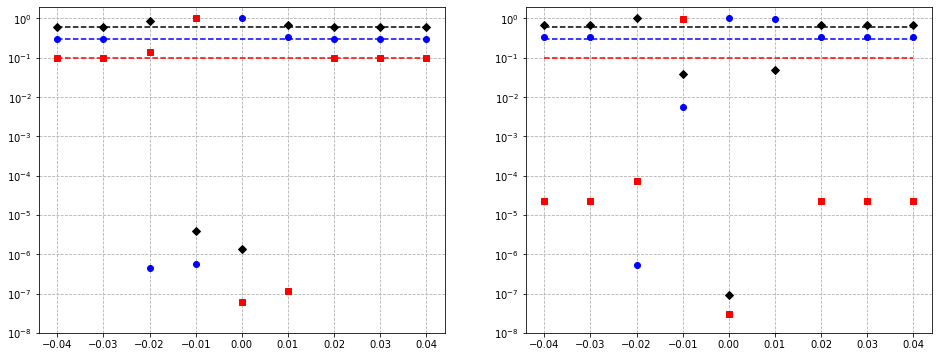

In [156]:
# Código que gera os gráficos comparando os pesos do WENO-Z e os pesos do WENO-Z
# modificados pela rede neural

# Criando os objetos que irão conter os plots
fig, axs = plt.subplots(1,2,figsize=(8*2, 6))

# Variáveis auxiliares para ajustar os limites dos gráficos
ylim  = (10**-8,2)
min_x = int(mid_point-(n_pontos-1)/2)
max_x = int(mid_point+(n_pontos+1)/2)

# Inserindo os pontos nos gráficos
axs[0].plot(x[min_x:max_x], y_plot_Z[:,0], 's', color='red'  , alpha=1)
axs[0].plot(x[min_x:max_x], y_plot_Z[:,1], 'D', color='black', alpha=1)
axs[0].plot(x[min_x:max_x], y_plot_Z[:,2], 'o', color='blue' , alpha=1)

# Criando as linhas horizontais dos gráficos
axs[0].hlines(
    y          = 1/10,
    xmin       = min(x[min_x:max_x]),
    xmax       = max(x[min_x:max_x]),
    color      = 'red',
    linestyles = '--'
)
axs[0].hlines(
    y          = 6/10,
    xmin       = min(x[min_x:max_x]),
    xmax       = max(x[min_x:max_x]),
    color      = 'black',
    linestyles = '--'
)
axs[0].hlines(
    y          = 3/10,
    xmin       = min(x[min_x:max_x]),
    xmax       = max(x[min_x:max_x]),
    color      = 'blue',
    linestyles = '--'
)

# Configuração de parâmetros gráficos referentes ao eixo y
axs[0].set_yscale('log')
axs[0].set_ylim(*ylim)
axs[0].yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
axs[0].grid(ls='--')

# Inserindo os pontos nos gráficos
axs[1].plot(x[min_x:max_x], y_plot_Rede[:,0], 's', color='red'  , alpha=1)
axs[1].plot(x[min_x:max_x], y_plot_Rede[:,1], 'D', color='black', alpha=1)
axs[1].plot(x[min_x:max_x], y_plot_Rede[:,2], 'o', color='blue' , alpha=1)

# Criando as linhas horizontais dos gráficos
axs[1].hlines(
    y          = 1/10,
    xmin       = min(x[min_x:max_x]),
    xmax       = max(x[min_x:max_x]),
    color      = 'red',
    linestyles = '--'
)
axs[1].hlines(
    y          = 6/10,
    xmin       = min(x[min_x:max_x]),
    xmax       = max(x[min_x:max_x]),
    color      = 'black',
    linestyles = '--'
)
axs[1].hlines(
    y          = 3/10,
    xmin       = min(x[min_x:max_x]),
    xmax       = max(x[min_x:max_x]),
    color      = 'blue',
    linestyles = '--'
)

# Configuração de parâmetros gráficos referentes ao eixo y
axs[1].set_yscale('log')
axs[1].set_ylim(*ylim)
axs[1].yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
axs[1].grid(ls='--')

# Exibindo os gráficos
plt.show()

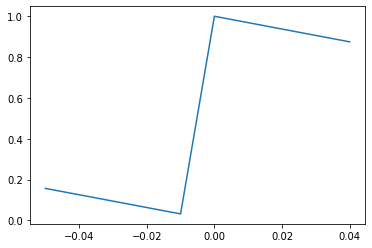

In [157]:
plt.plot(x[95:105],np.squeeze(u)[95:105])